# Demo of grid-searching ARIMA hyper-parameters (as used in vcap script)

Demonstration of how to grid-search ARIMA hyper-parameters. 
The dataset contains real-world capacity data of some Veeam Backup Repositories. <br><br>Check out the *vcap* Capacity Reporter Script [here](https://github.com/StefanSpecht/vcap) to see the grid-search algorithm in action! <br> A full ARIMA demo can be found [here](https://github.com/StefanSpecht/arima-demo/blob/master/arima-demo.ipynb). <br> <br>
Demo is based on the following tutorial: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

First, we load the repository capacity dataset and bring it in shape a little bit

In [1]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import warnings

df = pd.read_csv('repository_data.csv', header=0, index_col=0, parse_dates=True, dayfirst=True)
df['UsedGB'] = df['StorageTotal'] - df['StorageFree']
df = df[['Name', 'UsedGB', 'StorageTotal']]


Then, we filter the dataframe for the repository of interest and extract the time series

In [3]:
df = df[df['Name'] == "WTT_B201_Backup_01"]
series = pd.Series(df['UsedGB'])

Some dates migt be missing within the series, so let's re-index series and forward-fill missing values

In [4]:
date_range = pd.date_range(series.index[1].date(), series.index[-1].date())
series = series.reindex(date_range)
series.fillna(method='ffill', inplace=True)

Let's visualize the series by plotting it

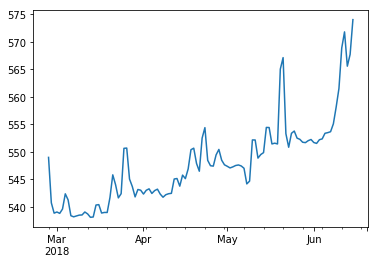

In [5]:
series.plot()
pyplot.show()

Define a function to evaluate an ARIMA model

In [6]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

Define the gridsearch function

In [7]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

Define search space and start grid-search

In [8]:
# evaluate parameters
p_values = range(0,5)
d_values = range(0, 2)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=135.589
ARIMA(0, 0, 1) MSE=40.029
ARIMA(0, 1, 0) MSE=17.605
ARIMA(0, 1, 1) MSE=17.934
ARIMA(0, 1, 2) MSE=10.935
ARIMA(0, 1, 3) MSE=11.172
ARIMA(0, 1, 4) MSE=10.821
ARIMA(1, 0, 0) MSE=19.563
ARIMA(1, 0, 1) MSE=14.941
ARIMA(1, 1, 0) MSE=17.539
ARIMA(1, 1, 1) MSE=13.575
ARIMA(2, 0, 0) MSE=19.643
ARIMA(2, 0, 1) MSE=14.264
ARIMA(2, 1, 0) MSE=13.231
ARIMA(2, 1, 1) MSE=13.544
ARIMA(2, 1, 2) MSE=11.763
ARIMA(2, 1, 3) MSE=10.523
ARIMA(3, 0, 0) MSE=14.166
ARIMA(3, 1, 0) MSE=13.703
ARIMA(3, 1, 1) MSE=13.777
ARIMA(4, 0, 0) MSE=14.698
ARIMA(4, 1, 0) MSE=13.451
ARIMA(4, 1, 1) MSE=11.082
Best ARIMA(2, 1, 3) MSE=10.523
